# Colab-related Steps

In [1]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1lOivZTHAAiHTconcVbF9PwrazsZoACqA'})
download.GetContentFile('Hotel_Reviews_Kaggle.csv')

download = drive.CreateFile({'id': '179jLFYiFJD_NcBAEZEe3Gl_eOnW2eJsJ'})
download.GetContentFile('Britannia International Hotel Canary Wharf.csv')

# Library Loading

In [2]:
#Core
import pandas as pd
import numpy as np

# Input Path

In [3]:
hotel_name = 'Britannia International Hotel Canary Wharf'
data_kaggle = "Hotel_Reviews_Kaggle.csv"
data_scraped = 'Britannia International Hotel Canary Wharf.csv'

data_scraped = pd.read_csv(data_scraped)
data_kaggle = pd.read_csv(data_kaggle)

# Cleaning Data Scraped from Booking.com

### Cleaning the "Review_date" column

In [4]:
data_scraped.head()

,Unnamed: 0,Name,Country,Room_stayed,Date_stayed,Trip_type,Review_date,Review_title,Positive,Negative,Reviewer_score
0,0,Anuj,India,Standard Double Room without Window,1 night · August 2020,Solo traveler,"Reviewed: August 17, 2020",Exceptional,Room quality.. hotel staff.. the bar..,There was cig box in the room which i think th...,10
1,1,B,United Kingdom,Standard Double Room,1 night · February 2021,Couple,"Reviewed: February 13, 2021",Good,"The bed, size of room, the bath tub feature in...",Dirty windows and dead bug found in the bath a...,7.0
2,2,Lex,United Kingdom,Standard Double Room,2 nights · February 2021,Solo traveler,"Reviewed: February 7, 2021",Good,I was made very welcome at the britania Hotel ...,Not Available,7.0
3,3,Rashida,United Kingdom,Standard Twin Room,1 night · January 2021,Couple,"Reviewed: February 1, 2021",It was a pleasant stay.,Location was brilliant.,The first room given was not clean. On notifyi...,7.0
4,4,Floyd,United Kingdom,Standard Double Room,1 night · January 2021,Solo traveler,"Reviewed: January 21, 2021",My stay was fantastic,Syl checked me in. She was friendly and profes...,Not Available,6.0


In [5]:
# We observed that there are some reviews without dates. Therefore, we clean them by indicating the dates of the 'neighbouring' reviews.
# This should be a reasonable assumption, since reviews are scraped in the order of appearance on the Booking.com site and they 
# appear in chronological order

# First, get the indices of the reviews where "Review_date" values are "Not Available"
not_avail_index = data_scraped[data_scraped.Review_date=='Not Available'].index
not_avail_index

Int64Index([  545,   582,   736,   743,  1142,  1144,  1963,  2676,  2726,
             2796,  2805,  2826,  2918,  2961,  3146,  3206,  3258,  3330,
             3603,  3710,  3875,  3908,  3972,  4010,  4046,  4082,  4215,
             4239,  4338,  4396,  4627,  4745,  4915,  4935,  5155,  5185,
             5252,  5357,  5399,  5550,  6483,  6742,  6916,  6966,  7439,
             8291, 11853, 12431],
           dtype='int64')

In [6]:
print(f"Number of Not Available left after cleaning: {len(data_scraped[data_scraped.Review_date=='Not Available'])}")

Number of Not Available left after cleaning: 48


In [7]:
# Define a function to take "neighbour's" Review Date
def repl_not_avail(df, own_index):
    df.loc[own_index, 'Review_date'] = df.loc[own_index+1, 'Review_date']

for i in not_avail_index:
    repl_not_avail(data_scraped, i)

In [8]:
# Check to ensure that we have replaced all 'Not Available' in the Review_date
print(f"Number of Not Available left after cleaning: {len(data_scraped[data_scraped.Review_date=='Not Available'])}")

Number of Not Available left after cleaning: 0


### Converting "Review_date" into Pandas date_time format

In [9]:
import string
from datetime import datetime

# Remove the "Reviewed" words in the "Review_date" column
data_scraped.Review_date = data_scraped.Review_date.apply(lambda x: x.replace('Reviewed: ',''))
data_scraped.head()

,Unnamed: 0,Name,Country,Room_stayed,Date_stayed,Trip_type,Review_date,Review_title,Positive,Negative,Reviewer_score
0,0,Anuj,India,Standard Double Room without Window,1 night · August 2020,Solo traveler,"August 17, 2020",Exceptional,Room quality.. hotel staff.. the bar..,There was cig box in the room which i think th...,10
1,1,B,United Kingdom,Standard Double Room,1 night · February 2021,Couple,"February 13, 2021",Good,"The bed, size of room, the bath tub feature in...",Dirty windows and dead bug found in the bath a...,7.0
2,2,Lex,United Kingdom,Standard Double Room,2 nights · February 2021,Solo traveler,"February 7, 2021",Good,I was made very welcome at the britania Hotel ...,Not Available,7.0
3,3,Rashida,United Kingdom,Standard Twin Room,1 night · January 2021,Couple,"February 1, 2021",It was a pleasant stay.,Location was brilliant.,The first room given was not clean. On notifyi...,7.0
4,4,Floyd,United Kingdom,Standard Double Room,1 night · January 2021,Solo traveler,"January 21, 2021",My stay was fantastic,Syl checked me in. She was friendly and profes...,Not Available,6.0


In [10]:
# Convert "Review_date" into consistent (numerical) format
from datetime import datetime

def string2date(string):
    return pd.to_datetime(datetime.strptime(string, '%B %d, %Y'))

data_scraped.Review_date = data_scraped.Review_date.apply(string2date)
data_scraped.head()

,Unnamed: 0,Name,Country,Room_stayed,Date_stayed,Trip_type,Review_date,Review_title,Positive,Negative,Reviewer_score
0,0,Anuj,India,Standard Double Room without Window,1 night · August 2020,Solo traveler,2020-08-17,Exceptional,Room quality.. hotel staff.. the bar..,There was cig box in the room which i think th...,10
1,1,B,United Kingdom,Standard Double Room,1 night · February 2021,Couple,2021-02-13,Good,"The bed, size of room, the bath tub feature in...",Dirty windows and dead bug found in the bath a...,7.0
2,2,Lex,United Kingdom,Standard Double Room,2 nights · February 2021,Solo traveler,2021-02-07,Good,I was made very welcome at the britania Hotel ...,Not Available,7.0
3,3,Rashida,United Kingdom,Standard Twin Room,1 night · January 2021,Couple,2021-02-01,It was a pleasant stay.,Location was brilliant.,The first room given was not clean. On notifyi...,7.0
4,4,Floyd,United Kingdom,Standard Double Room,1 night · January 2021,Solo traveler,2021-01-21,My stay was fantastic,Syl checked me in. She was friendly and profes...,Not Available,6.0


In [11]:
# Renaming headers so that they are consistent with the column headers of the dataframe downloaded from Kaggle
corrected_headers_dict = {
    'Review_date' : 'Review_Date',
    'Country' : 'Reviewer_Nationality',
    'Positive' : 'Positive_Review',
    'Negative' : 'Negative_Review',
    'Trip_type' : 'Guest_type'
}

data_scraped.rename(columns=corrected_headers_dict, inplace=True)
data_scraped.head()

,Unnamed: 0,Name,Reviewer_Nationality,Room_stayed,Date_stayed,Guest_type,Review_Date,Review_title,Positive_Review,Negative_Review,Reviewer_score
0,0,Anuj,India,Standard Double Room without Window,1 night · August 2020,Solo traveler,2020-08-17,Exceptional,Room quality.. hotel staff.. the bar..,There was cig box in the room which i think th...,10
1,1,B,United Kingdom,Standard Double Room,1 night · February 2021,Couple,2021-02-13,Good,"The bed, size of room, the bath tub feature in...",Dirty windows and dead bug found in the bath a...,7.0
2,2,Lex,United Kingdom,Standard Double Room,2 nights · February 2021,Solo traveler,2021-02-07,Good,I was made very welcome at the britania Hotel ...,Not Available,7.0
3,3,Rashida,United Kingdom,Standard Twin Room,1 night · January 2021,Couple,2021-02-01,It was a pleasant stay.,Location was brilliant.,The first room given was not clean. On notifyi...,7.0
4,4,Floyd,United Kingdom,Standard Double Room,1 night · January 2021,Solo traveler,2021-01-21,My stay was fantastic,Syl checked me in. She was friendly and profes...,Not Available,6.0


### Clean the entries in "Positive Review" and "Negative Review"

In [13]:
# Check for null values
data_scraped.isnull().sum()

# We can see that there are many reviews with null values. There are also many entries with "There are no comments available for this review".
# We convert them into a single letter, since we can reasonably assume that single-letter/single-word reviews are most likely to contain minimal information 
# about the guests' sentiments toward the hotel

Unnamed: 0                 0
Name                       0
Reviewer_Nationality       0
Room_stayed                0
Date_stayed                0
Guest_type                 0
Review_Date                0
Review_title               1
Positive_Review            8
Negative_Review         1816
Reviewer_score             0
dtype: int64

### We replace null/'meaningless' entries of Postive and Negative Reviews with a whitespace (so that it doesn't count as a 'word' for EDA later)

In [14]:
data_scraped.Positive_Review.fillna(' ', inplace=True) # Replace null values with "N"
data_scraped.Negative_Review.fillna(' ', inplace=True) # Replace null values with "N"

# We also convert 'meaningless' comments into whitespaces
rev_replace = {
    "There are no comments available for this review" : ' ',
    "This review is hidden because it doesn't meet our guidelines." : ' ',    
    "Not Available" : ' ',
    "N/a" : ' ',
    " N A" : ' ',
    "Na" : ' ',
    " N a" : ' ',
    " n a" : ' ', 
    " Na" : ' ',
    "...." : ' ',
    "No comments" : ' ',
    "Nothing to comment on here." : ' ',
    "No comment at this time." : ' ',
    "I had no complaints" : ' ',
    "No Negativity" :' '
}

data_scraped.Positive_Review.replace(to_replace=rev_replace, inplace=True)
data_scraped.Negative_Review.replace(to_replace=rev_replace, inplace=True)

In [15]:
data_scraped.isnull().sum()

Unnamed: 0              0
Name                    0
Reviewer_Nationality    0
Room_stayed             0
Date_stayed             0
Guest_type              0
Review_Date             0
Review_title            1
Positive_Review         0
Negative_Review         0
Reviewer_score          0
dtype: int64

# Create feature: Number of words in a review

In [16]:
# Define function to count the number of words in a review
def count_words(review_string):
  return len(review_string.split())

In [17]:
data_scraped['Review_Total_Positive_Word_Counts'] = data_scraped.Positive_Review.apply(count_words)
data_scraped['Review_Total_Negative_Word_Counts'] = data_scraped.Negative_Review.apply(count_words)

# All relevant information in scraped data required for EDA has now been cleaned

In [18]:
data_scraped.head()

,Unnamed: 0,Name,Reviewer_Nationality,Room_stayed,Date_stayed,Guest_type,Review_Date,Review_title,Positive_Review,Negative_Review,Reviewer_score,Review_Total_Positive_Word_Counts,Review_Total_Negative_Word_Counts
0,0,Anuj,India,Standard Double Room without Window,1 night · August 2020,Solo traveler,2020-08-17,Exceptional,Room quality.. hotel staff.. the bar..,There was cig box in the room which i think th...,10,6,14
1,1,B,United Kingdom,Standard Double Room,1 night · February 2021,Couple,2021-02-13,Good,"The bed, size of room, the bath tub feature in...",Dirty windows and dead bug found in the bath a...,7.0,15,15
2,2,Lex,United Kingdom,Standard Double Room,2 nights · February 2021,Solo traveler,2021-02-07,Good,I was made very welcome at the britania Hotel ...,,7.0,23,0
3,3,Rashida,United Kingdom,Standard Twin Room,1 night · January 2021,Couple,2021-02-01,It was a pleasant stay.,Location was brilliant.,The first room given was not clean. On notifyi...,7.0,3,17
4,4,Floyd,United Kingdom,Standard Double Room,1 night · January 2021,Solo traveler,2021-01-21,My stay was fantastic,Syl checked me in. She was friendly and profes...,,6.0,30,0


# Cleaning data downloaded from Kaggle

In [19]:
data_kaggle = data_kaggle[data_kaggle.Hotel_Name == hotel_name]
data_kaggle.reset_index(inplace = True, drop = True)
data_kaggle.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,31,9086,The location was excellent for getting to the O2,10,3,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221
1,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,34,9086,The house keeping lady made my boyfriends day...,14,3,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221
2,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/2/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,I asked how far the O2 was and got told a 7 m...,38,9086,No Positive,0,1,6.3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",1 days,51.50191,-0.023221
3,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/2/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Hot stuffy room air con not working properly ...,78,9086,The bed was OK,6,2,5.4,"[' Couple ', ' Standard Twin Room ', ' Stayed ...",1 days,51.50191,-0.023221
4,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/2/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Although the price seems like it is cheap you...,44,9086,The Receptionists and Cleaners are very polit...,36,4,6.3,"[' Leisure trip ', ' Family with young childre...",1 days,51.50191,-0.023221


### Clean the date entries so that the format is consistent with data in the scraped dataset

In [20]:
# Define function to convert date strings into Pandas date_time format
from datetime import datetime

def string2date_kaggle(string):
    return pd.to_datetime(datetime.strptime(string, '%m/%d/%Y'))

In [21]:
# Apply operation to create Pandas date_time object from date string
data_kaggle.Review_Date= data_kaggle.Review_Date.apply(string2date_kaggle)
data_kaggle.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2017-08-03,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,31,9086,The location was excellent for getting to the O2,10,3,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221
1,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2017-08-03,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,34,9086,The house keeping lady made my boyfriends day...,14,3,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221
2,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,I asked how far the O2 was and got told a 7 m...,38,9086,No Positive,0,1,6.3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",1 days,51.50191,-0.023221
3,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Hot stuffy room air con not working properly ...,78,9086,The bed was OK,6,2,5.4,"[' Couple ', ' Standard Twin Room ', ' Stayed ...",1 days,51.50191,-0.023221
4,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Although the price seems like it is cheap you...,44,9086,The Receptionists and Cleaners are very polit...,36,4,6.3,"[' Leisure trip ', ' Family with young childre...",1 days,51.50191,-0.023221


# Now, we're ready to merge the scraped data with the data downloaded from Kaggle

In [22]:
merged = pd.concat([data_kaggle, data_scraped], axis=0)
merged.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Unnamed: 0,Name,Room_stayed,Date_stayed,Guest_type,Review_title,Reviewer_score
0,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-03,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,31,9086.0,The location was excellent for getting to the O2,10,3.0,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-03,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,34,9086.0,The house keeping lady made my boyfriends day...,14,3.0,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,I asked how far the O2 was and got told a 7 m...,38,9086.0,No Positive,0,1.0,6.3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Hot stuffy room air con not working properly ...,78,9086.0,The bed was OK,6,2.0,5.4,"[' Couple ', ' Standard Twin Room ', ' Stayed ...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Although the price seems like it is cheap you...,44,9086.0,The Receptionists and Cleaners are very polit...,36,4.0,6.3,"[' Leisure trip ', ' Family with young childre...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Note: There are many null values but those are irrelvant for the purpose of EDA.

# After merging the data, we're ready to do EDA

### Visualise the number of positive and negative reviews (excluding 'meaningless' reviews)

In [23]:
num_positive_reviews = len(merged) - len(merged[merged.Positive_Review==' '])
num_negative_reviews = len(merged) - len(merged[merged.Negative_Review==' '])

In [39]:
print(f"Number of Positive Reviews: {num_positive_reviews}")
print(f"Number of Negative Reviews: {num_negative_reviews}")

Number of Positive Reviews: 13501
Number of Negative Reviews: 10023


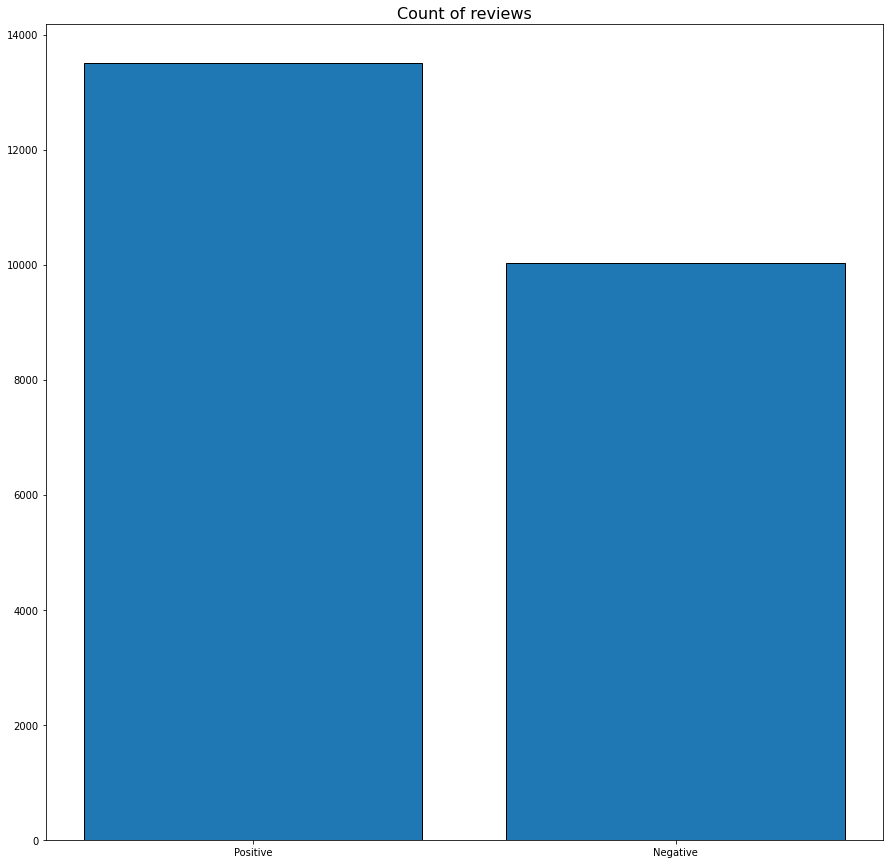

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.bar(['Positive', 'Negative'], [num_positive_reviews, num_negative_reviews], width=0.8, bottom=None, align='center', edgecolor='black')
plt.title('Count of reviews', fontsize=16)
plt.show()

### Visualise the number of reviews by months

In [27]:
# Create year-month feature
# Strip date to create 'year-month' column
merged['year'] = merged['Review_Date'].dt.year
merged['month'] = merged['Review_Date'].dt.month
merged.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Unnamed: 0,Name,Room_stayed,Date_stayed,Guest_type,Review_title,Reviewer_score,year,month
0,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-03,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,31,9086.0,The location was excellent for getting to the O2,10,3.0,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
1,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-03,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,34,9086.0,The house keeping lady made my boyfriends day...,14,3.0,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
2,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,I asked how far the O2 was and got told a 7 m...,38,9086.0,No Positive,0,1.0,6.3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
3,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Hot stuffy room air con not working properly ...,78,9086.0,The bed was OK,6,2.0,5.4,"[' Couple ', ' Standard Twin Room ', ' Stayed ...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
4,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Although the price seems like it is cheap you...,44,9086.0,The Receptionists and Cleaners are very polit...,36,4.0,6.3,"[' Leisure trip ', ' Family with young childre...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8


In [28]:
# Group by year-month
grp_by_date = merged.groupby(['year', 'month'], as_index=False).count()
grp_by_date.head()

,year,month,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Unnamed: 0,Name,Room_stayed,Date_stayed,Guest_type,Review_title,Reviewer_score
0,2015,8,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,0,0,0,0,0,0,0
1,2015,9,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,0,0,0,0,0,0,0
2,2015,10,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,0,0,0,0,0,0,0
3,2015,11,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,0,0,0,0,0,0,0
4,2015,12,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,0,0,0,0,0,0,0


In [29]:
# Create 'year-month' feature
for i in range(len(grp_by_date)):
  grp_by_date.loc[i,'year-month'] = str(grp_by_date.loc[i,'year']) + "-" +  str(grp_by_date.loc[i,'month'])
grp_by_date.head()

,year,month,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Unnamed: 0,Name,Room_stayed,Date_stayed,Guest_type,Review_title,Reviewer_score,year-month
0,2015,8,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,0,0,0,0,0,0,0,2015-8
1,2015,9,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,0,0,0,0,0,0,0,2015-9
2,2015,10,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,0,0,0,0,0,0,0,2015-10
3,2015,11,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,0,0,0,0,0,0,0,2015-11
4,2015,12,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,0,0,0,0,0,0,0,2015-12


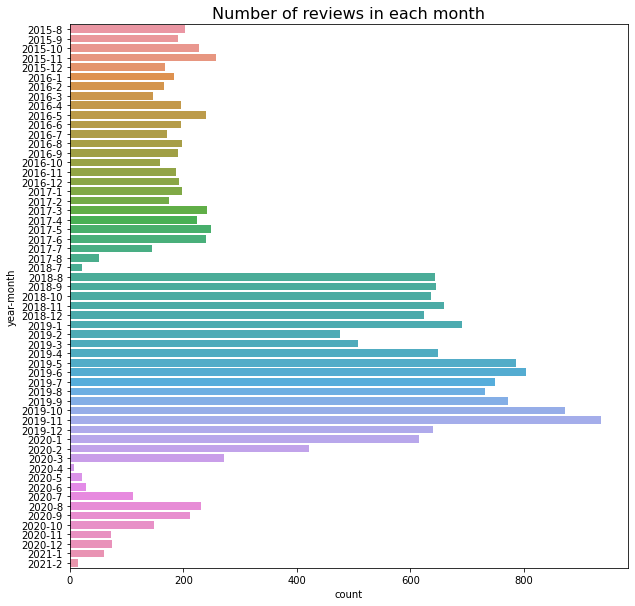

In [30]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.barplot(y='year-month', x='Review_Date', data=grp_by_date)
plt.xlabel('count')
plt.title('Number of reviews in each month', fontsize=16)
plt.show()

### Let's look at the top 20 nationalities of guests who provided reviews

In [31]:
# Define function to remove whitespaces in "Reviewer_Nationality" so that their names are consistent
def remove_whitespace(nationality_string):
  return nationality_string.replace(" ", "")

merged.Reviewer_Nationality = merged.Reviewer_Nationality.apply(remove_whitespace)

In [32]:
# Get top 20 Reviewer Nationalities based on the number of reviews provided
top_20_countries = merged.Reviewer_Nationality.value_counts()[:20].index
merged[merged.Reviewer_Nationality.isin(top_20_countries)]

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Unnamed: 0,Name,Room_stayed,Date_stayed,Guest_type,Review_title,Reviewer_score,year,month
0,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-03,7.1,Britannia International Hotel Canary Wharf,UnitedKingdom,The car park was small and unpleasant People ...,31,9086.0,The location was excellent for getting to the O2,10,3.0,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
1,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-03,7.1,Britannia International Hotel Canary Wharf,UnitedKingdom,We weren t told that the only spa facility op...,34,9086.0,The house keeping lady made my boyfriends day...,14,3.0,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
2,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,UnitedKingdom,I asked how far the O2 was and got told a 7 m...,38,9086.0,No Positive,0,1.0,6.3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
3,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,UnitedKingdom,Hot stuffy room air con not working properly ...,78,9086.0,The bed was OK,6,2.0,5.4,"[' Couple ', ' Standard Twin Room ', ' Stayed ...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
4,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-08-02,7.1,Britannia International Hotel Canary Wharf,UnitedKingdom,Although the price seems like it is cheap you...,44,9086.0,The Receptionists and Cleaners are very polit...,36,4.0,6.3,"[' Leisure trip ', ' Family with young childre...",1 days,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14138,NaN,NaN,2018-09-25,NaN,NaN,Poland,,0,NaN,,0,NaN,NaN,NaN,NaN,NaN,NaN,14138.0,Anonymous,2 nights · September 2018,Group,Not Available,Very Good,8.3,2018,9
14140,NaN,NaN,2018-09-15,NaN,NaN,Italy,,0,NaN,,0,NaN,NaN,NaN,NaN,NaN,NaN,14140.0,Anonymous,1 night · September 2018,Solo traveler,Not Available,Exceptional,10,2018,9
14141,NaN,NaN,2018-08-30,NaN,NaN,Germany,,0,NaN,,0,NaN,NaN,NaN,NaN,NaN,NaN,14141.0,Anonymous,1 night · August 2018,Family,Not Available,Wonderful,9.2,2018,8
14142,NaN,NaN,2018-08-28,NaN,NaN,UnitedKingdom,,0,NaN,,0,NaN,NaN,NaN,NaN,NaN,NaN,14142.0,Anonymous,1 night · August 2018,Couple,Not Available,Exceptional,10,2018,8


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


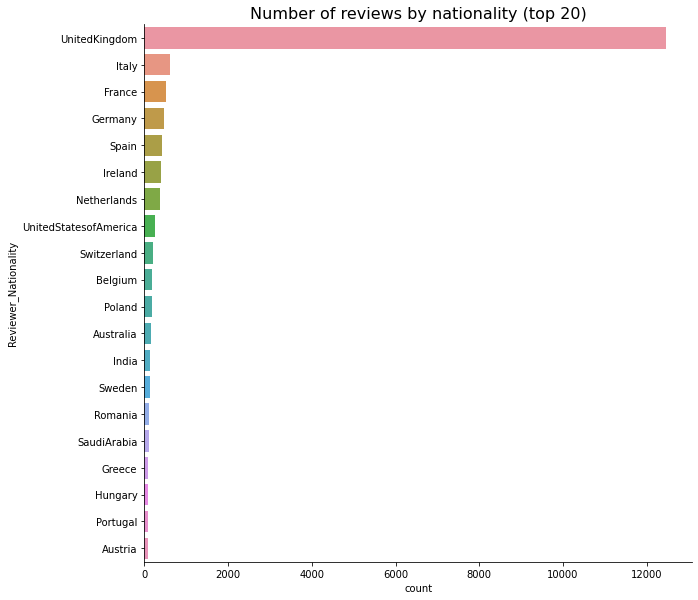

In [33]:
sns.factorplot(y="Reviewer_Nationality", data=merged, kind="count", order=merged[merged.Reviewer_Nationality.isin(top_20_countries)].Reviewer_Nationality.value_counts().index, size=8, aspect=1.2)
plt.title('Number of reviews by nationality (top 20)', fontsize=16)
plt.show()

### Interestingly, there is a nationality that is a whitespace (not shown in chart above) - perhaps guests didn't want to indicate that. We count how many of such instances there are

In [34]:
print(f"Number of reviews without nationality value indicated: {len(merged[merged.Reviewer_Nationality==''])}\n")
merged[merged.Reviewer_Nationality=='']

# Just 3 of them; unlikely to affect our analysis

Number of reviews without nationality value indicated: 3



,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Unnamed: 0,Name,Room_stayed,Date_stayed,Guest_type,Review_title,Reviewer_score,year,month
409,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-04-05,7.1,Britannia International Hotel Canary Wharf,,Useless bunch of people at hotel reception Ev...,41,9086.0,No Positive,0,1.0,5.4,"[' Business trip ', ' Solo traveler ', ' Stand...",120 day,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,4
548,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2017-02-18,7.1,Britannia International Hotel Canary Wharf,,I asked for poached eggs to the chef who told...,63,9086.0,To be fair most of the staff were very good b...,18,1.0,7.5,"[' Business trip ', ' Solo traveler ', ' Stand...",166 day,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,2
3537,163 Marsh Wall Docklands Tower Hamlets London ...,2682.0,2016-07-04,7.1,Britannia International Hotel Canary Wharf,,You had to pay extra for Wifi unfriendly staff,11,9086.0,Location and clean room and facilities,8,1.0,7.5,"[' Business trip ', ' Solo traveler ', ' Stand...",395 day,51.50191,-0.023221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,7


### Visualise the distribution of the number of words in Positive Reviews

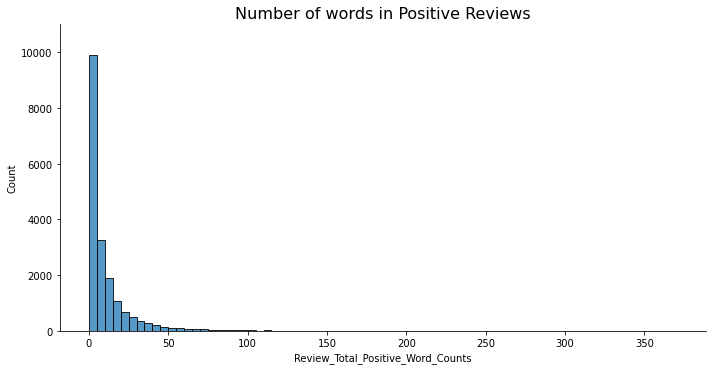

In [35]:
sns.displot(merged, x="Review_Total_Positive_Word_Counts", binwidth=5, height=5, aspect=2)
plt.ylim(0, 11000)
plt.title('Number of words in Positive Reviews', fontsize=16)
plt.show()

### Visualise the distribution of the number of words in Negative Reviews

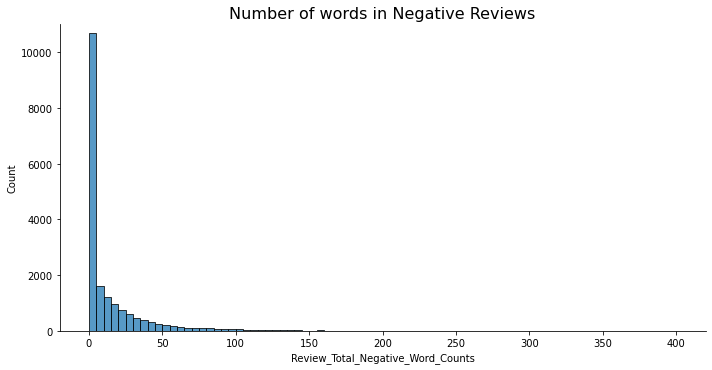

In [36]:
sns.displot(merged, x="Review_Total_Negative_Word_Counts", binwidth=5, height=5, aspect=2)
plt.ylim(0, 11000)
plt.title('Number of words in Negative Reviews', fontsize=16)
plt.show()

### Visualise the number of words by nationalities

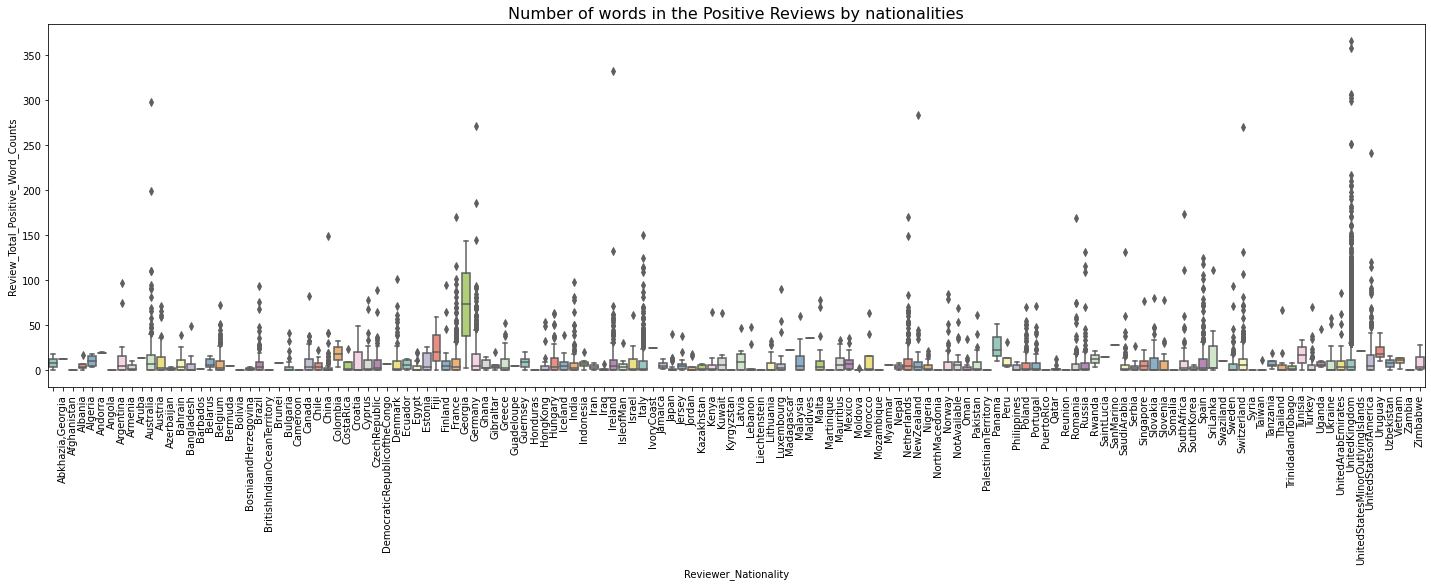

In [37]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="Reviewer_Nationality", y="Review_Total_Positive_Word_Counts", data=merged.sort_values('Reviewer_Nationality'), palette="Set3")
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Number of words in the Positive Reviews by nationalities', fontsize=16)
plt.show()

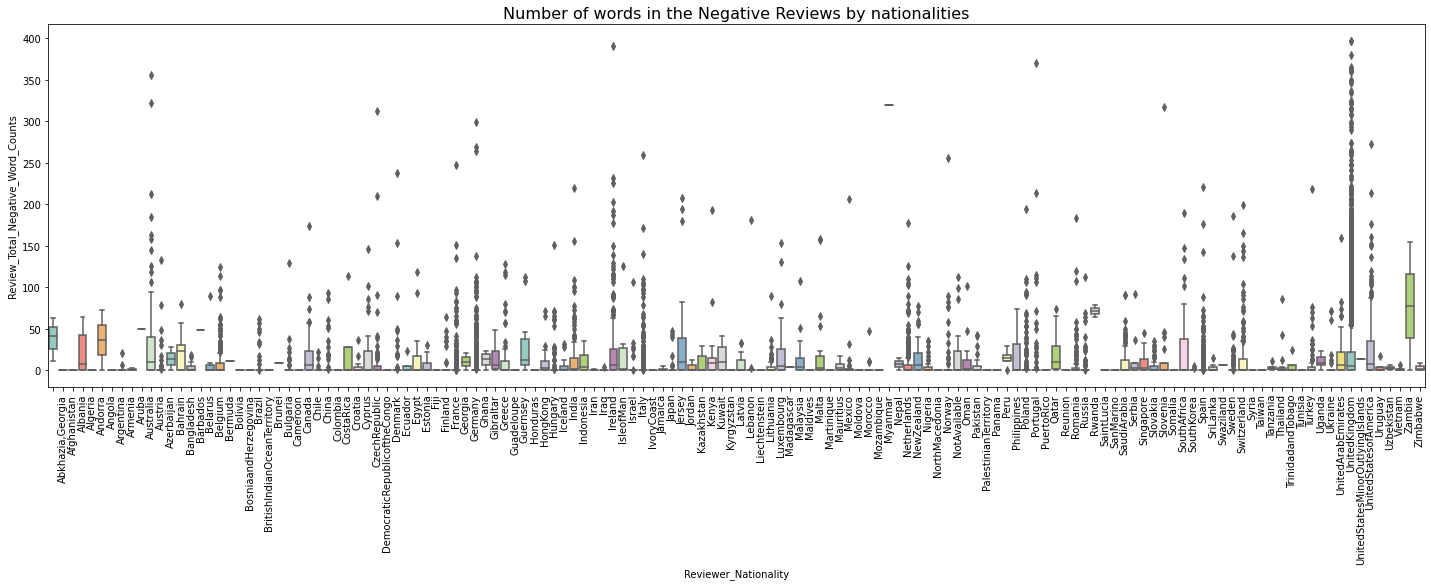

In [38]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="Reviewer_Nationality", y="Review_Total_Negative_Word_Counts", data=merged.sort_values('Reviewer_Nationality'), palette="Set3")
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Number of words in the Negative Reviews by nationalities', fontsize=16)
plt.show()

End of EDA